In [ ]:
from atproto import Client
import json
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

client = Client()

client.login(json.load(open("../data/bluesky_creds.json"))['login'], json.load(open("../data/bluesky_creds.json"))['password'])

ProfileViewDetailed(did='did:plc:ndhluqppcqyezrevmomju6p6', handle='tonykellyeu.bsky.social', associated=ProfileAssociated(chat=None, feedgens=0, labeler=False, lists=0, starter_packs=0, py_type='app.bsky.actor.defs#profileAssociated'), avatar='https://cdn.bsky.app/img/avatar/plain/did:plc:ndhluqppcqyezrevmomju6p6/bafkreigm4reaqe4wtn4ptwo6zufrx52apxnadf4vfnj4ko3jiafpfybp4y@jpeg', banner=None, created_at='2025-02-24T09:41:59.544Z', description=None, display_name='', followers_count=1, follows_count=1, indexed_at='2025-02-24T09:42:51.844Z', joined_via_starter_pack=None, labels=[], pinned_post=None, posts_count=0, viewer=ViewerState(blocked_by=False, blocking=None, blocking_by_list=None, followed_by=None, following=None, known_followers=None, muted=False, muted_by_list=None, py_type='app.bsky.actor.defs#viewerState'), py_type='app.bsky.actor.defs#profileViewDetailed')

gets batches of 100 

In [ ]:
# import os
# import sys
# sys.path.append('../src')
# from data_analysis import posts_df, retrieve_posts, textblob_analy

In [2]:
#helper functions
# Extract relevant information from posts
def posts_df(posts):
    data = []
    for post in posts:
        data.append({
            "Post URI": post.uri,
            "Content": post.record.text,
            "Author": post.author.handle,
            "Timestamp": post.indexed_at,
            "Likes": post.like_count,
            "Replies": post.reply_count,
            "Reposts": post.repost_count
        })

    # Create DataFrame
    df = pd.DataFrame(data)
    return df

def retrieve_posts(params):
    all_posts = []
    while True:
        resp = client.app.bsky.feed.search_posts(params=params)
        posts = resp.posts
        print(f"Retrieved {len(posts)} posts")
        if len(posts) <=1:
            break
        all_posts.extend(posts)
        params['until'] = posts[-1].indexed_at

    #df=posts_df(all_posts)
    all_posts
    return all_posts


from textblob import TextBlob
def textblob_analy(df):
    p=[]
    s=[]
    for c in df['Content']:
        blob = TextBlob(c)
        sentiment = blob.sentiment
        p.append(round(sentiment.polarity, 3))
        s.append(round(sentiment.subjectivity, 2))
        #print(f"Polarity: {round(sentiment.polarity, 2)}, Subjectivity: {round(sentiment.subjectivity, 2)}")
        #print(f"Polarity: {sentiment.polarity}, Subjectivity: {round(sentiment.subjectivity, 2)}")

    df['subjectivity']=s
    df['polarity']=p

In [ ]:
# # loop over many 100 batched 
# #define time point eg after election till now

# params = {'q': 'germany election', 'limit': 100,
#           'since': '2025-02-15T12:00:00Z', 'until' : '2025-02-23T12:00:00Z'
#           }

# all_posts = retrieve_posts(params)
# df=posts_df(all_posts)
# textblob_analy(df)
# df.to_json('../data/before_posts.json', orient='records', lines=True)

In [ ]:
# params = {'q': 'germany election', 'limit': 100,
#           'since': '2025-02-23T12:00:00Z', 'until' : '2025-02-27T12:00:00Z'
#           }

# all_posts = retrieve_posts(params)
# df=posts_df(all_posts)
# textblob_analy(df)
# df.to_json('../data/after_posts.json', orient='records', lines=True)

just use the already retrieved posts

In [3]:
df_b = pd.read_json('../data/before_posts.json', orient='records', lines=True)
df_a = pd.read_json('../data/after_posts.json', orient='records', lines=True)

try for individual parties

In [ ]:
params = {'q': 'germany election AFD', 'limit': 100,
          'since': '2025-02-22T12:00:00Z', 'until' : '2025-02-23T12:00:00Z'
          }
all_posts = retrieve_posts(params)
afd_df=posts_df(all_posts)
textblob_analy(afd_df)
afd_df.to_json('../data/afd_posts.json', orient='records', lines=True)


In [ ]:
import plotly.graph_objects as go

fig = go.Figure(
    data=[
        go.Scatter(x=df_b['polarity'], y=df['subjectivity'],
            mode="markers",
            marker={"size": 5},
            text=df['Content'],
            hovertemplate="<b>Polarity: %{x:.2f}</b><br>" +
            "Subjectivity: %{y:.2f}<br>" +
            "Content: %{text}<br>" +
            "<extra></extra>"
                   ),
        go.Scatter(x=df_a['polarity'], y=afd_df['subjectivity'],
            mode="markers",
            marker={"size": 5, "color": "red"},
            text=afd_df['Content'],
            hovertemplate="<b>Polarity: %{x:.2f}</b><br>" +
            "Subjectivity: %{y:.2f}<br>" +
            "Content: %{text}<br>" +
            "<extra></extra>"
                   )
    ],
    layout=go.Layout(title=go.layout.Title(text="subjectivity vs polarity"))
)

fig.show()

I like the scatter plots but they are difficult to parse quickly 
Maybe be easier to plot the histograms or density plots and look at shifts in the distribution

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
# sns.histplot(data=df, x='subjectivity', ax=ax)
# sns.histplot(data=AFD_df, x='subjectivity', ax=ax, color='red')

sns.kdeplot(df_b, x='subjectivity', fill=True, label='Distribution 1', bw_adjust=0.5)
sns.kdeplot(df_a, x='subjectivity', fill=True, label='Distribution 2', bw_adjust=0.5)


In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

def filter_words(df):
    filtered = []
    for reviews in df['Content']:
        word_tokens = word_tokenize(reviews)
        for w in word_tokens:
                if w not in stop_words and w.isalpha():
                    filtered.append(w)
    return (filtered)

In [ ]:
filter_words(df)

In [11]:
df_a['period']='after'
df_b['period']='before'
df=pd.concat([df_a, df_b])

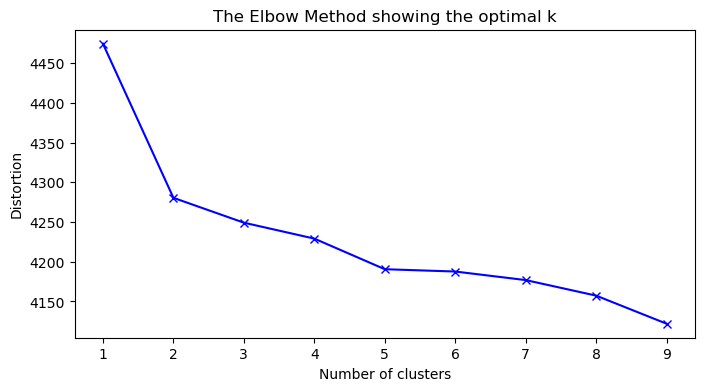

In [12]:
def plot_elbow_method(dfs):
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(dfs["Content"])

    distortions = []
    K = range(1, 10)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        distortions.append(kmeans.inertia_)
    
    plt.figure(figsize=(8, 4))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

plot_elbow_method(df)

In [13]:
def vectorise_posts(df):
    # Vectorize the posts using TF-IDF
    vectorizer = TfidfVectorizer(stop_words='english')
    matrix = vectorizer.fit_transform(df['Content']).toarray()
    feature_names = vectorizer.get_feature_names_out()
    df_tfidf = pd.DataFrame(matrix, columns=feature_names)
    #print(df_tfidf)

    X = vectorizer.fit_transform(df["Content"])

    # Determine the optimal number of clusters using the elbow method
    import matplotlib.pyplot as plt



    return X, matrix, feature_names, df_tfidf

X, matrix, feature_names, df_tfidf = vectorise_posts(df)

In [14]:
# Cluster the posts using K-Means
num_clusters = 5  # Set the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

# Add the cluster labels to the DataFrame
df["Cluster"] = kmeans.labels_

# Display the clustered DataFrame
print(df[['Content','Cluster', 'Likes']])

                                                Content  Cluster  Likes
0     Make no mistake. Yes, it seems that multi-part...        2     10
1     🇩🇪 🗳️ @jannikjansen.bsky.social, @lindnerjs.bs...        2      4
2     We need a true leader who will demand an audit...        4      0
3     We need a true leader who will demand an audit...        4      2
4     We need a true leader who will demand an audit...        4      0
...                                                 ...      ...    ...
1988  2/2\nOn Feb. 23 we'll have elections in German...        2      1
1989  2/2\nOn Feb. 23 we'll have elections in German...        2      1
1990  oh... & btw: #IVoteVolt! in the upcoming #elec...        2      1
1991  The european leaders are piiiiiiiiissed. It's ...        2      8
1992  At 23.02.25 we will have election-day!\n\nWe h...        2     21

[4580 rows x 3 columns]


In [16]:
# Import Latent Dirichlet Allocation
from sklearn.decomposition import LatentDirichletAllocation

# Apply LDA to the TF-IDF matrix
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(matrix)

# Display the topics
def display_topics(model, feature_names, no_top_words):
	for topic_idx, topic in enumerate(model.components_):
		print("Topic %d:" % (topic_idx))
		print(" ".join([feature_names[i]
						for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, feature_names, no_top_words)

# Get the topic distribution for each document
topic_distribution = lda.transform(matrix)
df["Topic"] = topic_distribution.argmax(axis=1)

Topic 0:
germany election afd german results right 2025 www vote today
Topic 1:
germany right election far party afd merz german friedrich cdu
Topic 2:
germany election musk trump afd power nazis hitler government german
Topic 3:
election germany audit elon turnout france true canada demand non
Topic 4:
doing countries thing currently spread started nations substack musks interference


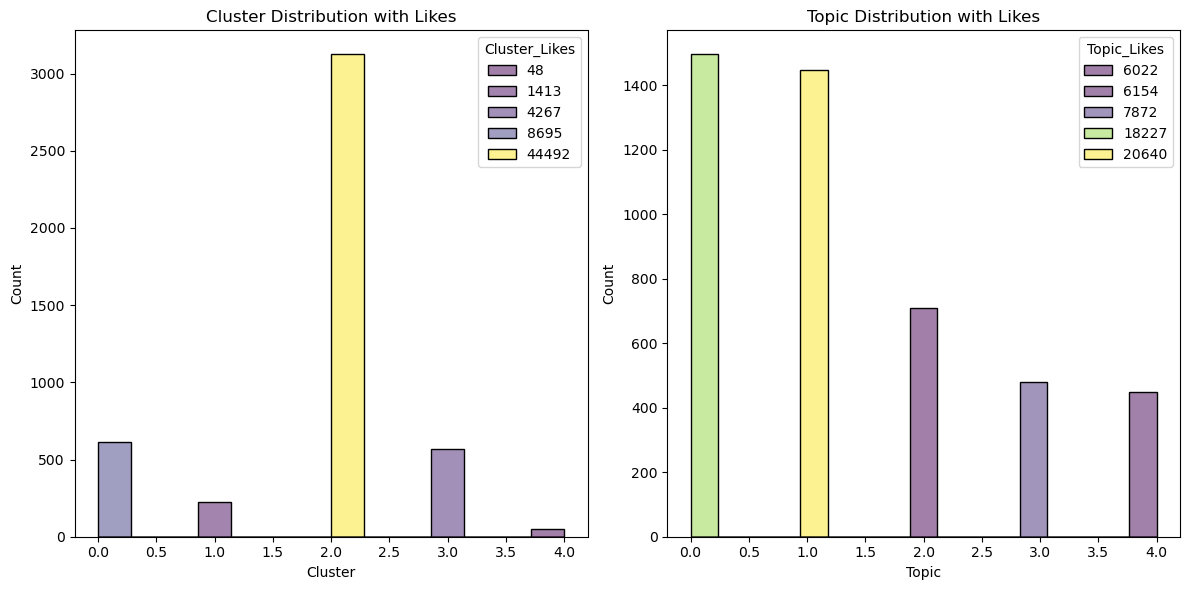

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

#get sum likes
df['Cluster_Likes'] = df.groupby('Cluster')['Likes'].transform('sum')
df['Topic_Likes'] = df.groupby('Topic')['Likes'].transform('sum')

sns.histplot(df, x='Cluster', hue='Cluster_Likes', palette='viridis', ax=ax[0])
ax[0].set_title('Cluster Distribution with Likes')

df['Topic_Likes'] = df.groupby('Topic')['Likes'].transform('sum')

sns.histplot(df, x='Topic', hue='Topic_Likes', palette='viridis', ax=ax[1])
ax[1].set_title('Topic Distribution with Likes')

plt.tight_layout()
plt.show()

In [ ]:
cl0 = df[df['Cluster'] == 0]
cl1 = df[df['Cluster'] == 1]
cl2 = df[df['Cluster'] == 2]
cl3 = df[df['Cluster'] == 3]
cl4 = df[df['Cluster'] == 4]

#indicies
cl0_indices = cl0.index
cl1_indices = cl1.index
cl2_indices = cl2.index
cl3_indices = cl3.index
cl4_indices = cl4.index

# TF-IDF values for the posts in the cluster
cl0_tfidf = matrix[cl0_indices]
cl1_tfidf = matrix[cl1_indices]


#mean TF-IDF score for each word in cluster 1
cl0_mean_tfidf = cl0_tfidf.mean(axis=0)
cl1_mean_tfidf = cl1_tfidf.mean(axis=0)

# words with the highest mean TF-IDF scores
top_words_indices = cl1_mean_tfidf.argsort()[::-1][:10]
top_words = [feature_names[i] for i in top_words_indices]

print("Top words for cluster 2:", top_words)

Top words for cluster 2: ['germany', 'election', 'afd', 'party', 'german', 'results', 'right', 'merz', 'trump', 'victory']


In [ ]:
# try to get top word for each cluster and get unique words WORKIN
def top_words(df):
    top_words={}
    
    for i in cluster:
        cl = df[df['Cluster'] == 0]
    

    #indicies
    cl0_indices = cl0.index
    cl1_indices = cl1.index
    cl2_indices = cl2.index
    cl3_indices = cl3.index
    cl4_indices = cl4.index

    # TF-IDF values for the posts in the cluster
    cl0_tfidf = matrix[cl0_indices]
    cl1_tfidf = matrix[cl1_indices]


    # Calculate the mean TF-IDF score for each word in cluster 1
    cl0_mean_tfidf = cl0_tfidf.mean(axis=0)
    cl1_mean_tfidf = cl1_tfidf.mean(axis=0)

    # Get the words with the highest mean TF-IDF scores
    top_words_indices = cl1_mean_tfidf.argsort()[::-1][:10]
    top_words = [feature_names[i] for i in top_words_indices]

    print("Top words for cluster 2:", top_words)